# **Modelos ResNET**
Búsqueda del mejor modelo para la tarea

Entrenar y comparar **ResNet18, ResNet34** sobre los volúmenes `.npy` de resonancia magnética.

**Características principales:**
- Volúmenes: `(160,192,192)`
- Se extraen 10/20 cortes axiales centrales
- Entrada redimensionada a `224×224` (para ResNet)
- Pérdida: `BCEWithLogitsLoss` con `pos_weight` (para balanceo)
- Evaluación: **Balanced Accuracy (BAC)**
- Modelos con **Batch Normalization**.


In [ ]:
import os, torch
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from typing import List, Dict, Any, Tuple

CSV_PATH = '../Data/Tabular.csv'
FOLDER_PATH = r"C:\Users\usuario\MRI\IMAGES_npy"
OUTPUT_DIR = "../Models_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
IMAGE_SHAPE = (1, 160, 192, 192)

_________________

### Sobre las imagenes

In [ ]:
# [] Atributos de las imégenes
shapes, means, stds, size = [], [], [], []

for f in os.listdir(FOLDER_PATH):
    if f.endswith(".npy"):
        img = np.load(os.path.join(FOLDER_PATH, f))
        shapes.append(img.shape)
        means.append(img.mean())
        stds.append(img.std())
        size.append(img.size)

# Contar shapes únicos
shapes_unicos = set(shapes)
size_unicos = set(size)
print("Shapes únicos encontrados:", shapes_unicos)
print("Total de imágenes:", len(shapes))
print(f"Media global promedio: {np.mean(means):.4f}")
print(f"Desviación global promedio: {np.mean(stds):.4f}")
print(f"Size únicos: {size_unicos}")

Shapes únicos encontrados: {(160, 192, 192)}
Total de imágenes: 220
Media global promedio: 0.0000
Desviación global promedio: 1.0000
Size únicos: {5898240}


In [ ]:
# [] Atributos
df = pd.read_csv(CSV_PATH, dtype={'sujeto_id': str})
df = df.dropna(subset=['is_dementia'])
df['sujeto_id'] = df['sujeto_id'].str.strip()
df['file_path'] = df['imagen_id'].apply(
    lambda x: os.path.join(FOLDER_PATH, f"{x}.npy")
)
df = df[['file_path', 'sujeto_id', 'is_dementia']].copy()
df.rename(columns={'is_dementia': 'label'}, inplace=True)
records: List[Dict[str, Any]] = df.to_dict('records')
print(f"Total de registros a procesar: {len(records)}")


Total de registros a procesar: 220


In [50]:
# 1. Distribución básica de is_dementia
class_distribution = df['label'].value_counts().sort_index()
print("=== DISTRIBUCIÓN DE CLASES ===")
print(f"Clase 0 (No Dementia): {class_distribution.get(0, 0)} imágenes - {class_distribution.get(0, 0)/len(df)*100:.2f}%")
print(f"Clase 1 (Dementia): {class_distribution.get(1, 0)} imágenes - {class_distribution.get(1, 0)/len(df)*100:.2f}%")
class_distribution = df['label'].value_counts().sort_index()
N = len(df)
count_dementia = class_distribution.get(1, 0)
expected_proportion = 0.5 
z_stat, p_value = proportions_ztest(count=count_dementia, 
                                    nobs=N, 
                                    value=expected_proportion, 
                                    alternative='two-sided')
print(f"Estadístico Z: {z_stat:.4f}")
print(f"Valor p: {p_value:.4e}")
# Conclusión
alpha = 0.05
if p_value < alpha:
    print(f"\nConclusión: Se rechaza H0. La proporción de la Clase 1 ({count_dementia/N*100:.2f}%) es SIGNIFICATIVAMENTE diferente de {expected_proportion*100:.0f}%.")
else:
    print(f"\nConclusión: No se rechaza H0. No hay evidencia suficiente para decir que la proporción es diferente de {expected_proportion*100:.0f}%.")

=== DISTRIBUCIÓN DE CLASES ===
Clase 0 (No Dementia): 158 imágenes - 71.82%
Clase 1 (Dementia): 62 imágenes - 28.18%
Estadístico Z: -7.1933
Valor p: 6.3244e-13

Conclusión: Se rechaza H0. La proporción de la Clase 1 (28.18%) es SIGNIFICATIVAMENTE diferente de 50%.


## Modelo

In [51]:
# [Func] 

def group_stratified_split(
    records: List[Dict[str, Any]], 
    train_size: float = 0.7, val_size: float = 0.15, test_size: float = 0.15, 
    seed: int = 42
) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]], List[Dict[str, Any]]]:

    df = pd.DataFrame(records)
    
    # 1. Determinar el label de cada sujeto
    subj_lab = df.groupby("sujeto_id")["label"].agg(lambda x: int(round(x.mean())))
    subjects = subj_lab.index.to_list()
    y = subj_lab.values # Labels a nivel de sujeto

    # 2. Split Inicial (Train vs. Resto) con GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
    
    train_idx, rest_idx = next(gss.split(subjects, y, groups=subjects))
    train_subj = [subjects[i] for i in train_idx]
    rest_subj = [subjects[i] for i in rest_idx]

    # 3. Split del Resto (Validation vs. Test) con Stratify
    val_prop = val_size / (val_size + test_size)
    
    # Preparamos los labels del 'resto' para la estratificación
    rest_labels = [subj_lab[s] for s in rest_subj]
    
    val_subj, test_subj = train_test_split(
        rest_subj, 
        test_size=1 - val_prop, 
        random_state=seed, 
        stratify=rest_labels
    )

    # 4. Reunir los registros (imágenes) por sujeto
    def select_by_subject(subj_list):
        return [r for r in records if r["sujeto_id"] in subj_list]

    return select_by_subject(train_subj), select_by_subject(val_subj), select_by_subject(test_subj)

In [2]:
import os, glob, math, random, time, json, torch_directml
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnet18, resnet34, resnet50
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights


from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, confusion_matrix

print('PyTorch version', torch.__version__)

PyTorch version 2.4.1+cpu


In [4]:
# Helper functions: intensity normalization, slice extraction
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def contrast_normalize_volume(vol, pmin=2, pmax=98):     
    vmin = np.percentile(vol, pmin)    
    vmax = np.percentile(vol, pmax)    
    vol = np.clip(vol, vmin, vmax)    
    vol = (vol - vmin) / (vmax - vmin + 1e-9)    
    return vol.astype(np.float32)

def get_central_slices(vol, n_slices=10):  
    """ Extract n central axial slices from a volume shaped.   """
    D = vol.shape[0]    
    center = D // 2    
    half = n_slices // 2   
    start = max(0, center - half)    
    end = min(D, start + n_slices)
    slices = vol[start:end]
    if slices.shape[0] < n_slices:  # padding si faltan
        pad_before = (n_slices - slices.shape[0]) // 2
        pad_after = n_slices - slices.shape[0] - pad_before
        slices = np.concatenate([
            np.repeat(slices[[0]], pad_before, axis=0),
            slices,
            np.repeat(slices[[-1]], pad_after, axis=0)
        ], axis=0)
    return slices

In [ ]:
# Dataset: loads one volume per item and returns tensor of shape (n_slices, C, H, W)

class MRIVolumeDataset(Dataset):
    def __init__(self, records, n_slices=10, target_size=(224,224), transform=None, skull_strip=False):
        self.records = records        
        self.n_slices = n_slices        
        self.target_size = target_size        
        self.transform = transform        
        self.skull_strip = skull_strip    
        
    def __len__(self):        
        return len(self.records)
        
    def __getitem__(self, idx):
        rec = self.records[idx]
        vol = np.load(rec['path'])  # Volumen (160,192,192)

        vol = contrast_normalize_volume(vol)
        slices = get_central_slices(vol, self.n_slices)

        imgs = []
        for s in slices:
            img = Image.fromarray((s * 255).astype(np.uint8))
            img = img.resize(self.target_size)
            img = img.convert("RGB")

            if self.transform:
                img = self.transform(img)
            else:
                img = T.Compose([
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])(img)
            imgs.append(img)

        imgs = torch.stack(imgs, dim=0)  # (n_slices, C, H, W)
        label = torch.tensor(rec['label'], dtype=torch.float32)
        
        return imgs, label, rec['sujeto_id']  

In [6]:
# [Clase] Modelo RestNet
class ResNetSliceClassifier(nn.Module):
    def __init__(self, backbone_name='resnet18', pretrained=False, n_slices=10, dropout=0.4):
        super().__init__()
        self.n_slices = n_slices

        if backbone_name == 'resnet18':
            base = resnet18(weights=None if not pretrained else ResNet18_Weights.DEFAULT)
            feat_dim = base.fc.in_features

        elif backbone_name == 'resnet34':
            base = resnet34(weights=None if not pretrained else ResNet34_Weights.DEFAULT)
            feat_dim = base.fc.in_features
        else:
            raise ValueError(f"Modelo no soportado: {backbone_name}")
        # Secuencia de la red
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(feat_dim, 1)

    # Paso forward
    def forward(self, x):
        B, S, C, H, W = x.shape
        x = x.view(B*S, C, H, W)
        feats = self.backbone(x)
        feats = self.global_pool(feats).view(B, S, -1)
        agg = feats.mean(dim=1)
        out = self.dropout(agg)
        logits = self.classifier(out).squeeze(1)
        return logits


In [7]:
def build_records(data_dir, labels_csv):
    labels_df = pd.read_csv(labels_csv, dtype={'sujeto_id': str})
    labels_df = labels_df.dropna(subset=['is_dementia']) # Excluir imágenes sin datos
    labels_df['sujeto_id'] = labels_df['sujeto_id'].str.strip()
    label_map = dict(zip(labels_df['sujeto_id'], labels_df['is_dementia']))

    records = []
    for p in glob.glob(os.path.join(data_dir, "*.npy")):
        subj = os.path.basename(p)[:10].strip()
        if subj in label_map:
            records.append({"path": p, "sujeto_id": subj, "label": int(label_map[subj])})
    return records

# División estratificada
def group_stratified_split(records, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    df = pd.DataFrame(records)
    subj_lab = df.groupby("sujeto_id")["label"].agg(lambda x: int(round(x.mean())))
    subjects = subj_lab.index.to_list()
    y = subj_lab.values

    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
    train_idx, rest_idx = next(gss.split(subjects, y, groups=subjects))
    train_subj = [subjects[i] for i in train_idx]
    rest_subj = [subjects[i] for i in rest_idx]

    val_prop = val_size / (val_size + test_size)
    val_subj, test_subj = train_test_split(rest_subj, test_size=1 - val_prop, random_state=seed, stratify=[subj_lab[s] for s in rest_subj])

    def select_by_subject(subj_list):
        return [r for r in records if r["sujeto_id"] in subj_list]

    return select_by_subject(train_subj), select_by_subject(val_subj), select_by_subject(test_subj)


In [8]:
def compute_class_weights(records):
    labels = [r['label'] for r in records]
    cnt0 = sum(l == 0 for l in labels)
    cnt1 = sum(l == 1 for l in labels)
    pos_weight = torch.tensor([cnt0 / (cnt1 + 1e-9)], dtype=torch.float32)
    return pos_weight, cnt0, cnt1


def evaluate_model(model, dataloader, device):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for X, y, _ in dataloader:
            X, y = X.to(device), y.to(device)
            probs = torch.sigmoid(model(X)).cpu().numpy()
            preds.extend((probs >= 0.5).astype(int))
            ys.extend(y.cpu().numpy().astype(int))
    return balanced_accuracy_score(ys, preds)

# Entrenamiento por épocas
def train_one_model(model, train_loader, val_loader, device, pos_weight, lr=1e-4, epochs=10, patience=5):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    
    best_bac = 0
    best_state = None
    patience_counter = 0
    history = {"epoch": [], "train_loss": [], "val_bac": []}
    time_1 = time.time()

    for e in range(epochs):
        epoch_start = time.time()
        # Entrenamiento
        model.train()
        total_loss = 0
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        val_bac = evaluate_model(model, val_loader, device)

        epoch_time = time.time() - epoch_start
        avg_loss = total_loss / len(train_loader)

        print(f"Epoch {e+1}/{epochs} | Loss {total_loss/len(train_loader):.4f} | Val BAC {val_bac:.4f} | Tiempo {epoch_time/60:.2f} minutos")
        
        # Guardar historia
        history["epoch"].append(e + 1)
        history["train_loss"].append(avg_loss)
        history["val_bac"].append(val_bac)

        # Early stopping
        if val_bac > best_bac:
            best_bac = val_bac
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping activado en epoch {e+1}")
                break

    total_time = time.time() - time_1
    print(f"Entrenamiento completo en {total_time/60:.2f} minutos")
    model.load_state_dict(best_state)
    return model, history


In [9]:
# Graficar rendimiento
def plot_training_history(history, model_name="modelo"):
    plt.figure(figsize=(8, 4))
    plt.plot(history["epoch"], history["train_loss"], label="Train Loss", marker="o")
    plt.plot(history["epoch"], history["val_bac"], label="Val Balanced Accuracy", marker="s")
    plt.xlabel("Época")
    plt.ylabel("Valor")
    plt.title(f"Evolución del entrenamiento - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Guardar imagen
    filename = f"models_output/history_{model_name}.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Gráfico guardado en: {filename}")

In [10]:
def main(dry_run=True):
    records = build_records(DATA_DIR, LABELS_CSV)
    print(f"Volúmenes encontrados: {len(records)}")
    train_recs, val_recs, test_recs = group_stratified_split(records, seed = SEED)
    pos_weight, c0, c1 = compute_class_weights(train_recs)
    print(f"Clases: 0={c0}, 1={c1}, pos_weight={pos_weight.item():.2f}")
    print(f"Bach {BATCH_SIZE}, slices {N_SLICES}, epocas {EPOCHS}")

    transform = T.Compose([
        T.RandomHorizontalFlip(0.5),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    # Extraer imágenes
    train_ds = MRIVolumeDataset(train_recs, transform=transform)
    val_ds = MRIVolumeDataset(val_recs)
    test_ds = MRIVolumeDataset(test_recs)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    if dry_run:
        X, y, _ = next(iter(train_loader))
        print("Ejemplo:", X.shape, y.shape)
        return

    # Estructura principal
    results = []
    for backbone in ['resnet18','resnet34']:
        print(f"\n=== Entrenando {backbone} ===")
        model = ResNetSliceClassifier(backbone, n_slices=N_SLICES) # type: ignore
        trained, history = train_one_model(model, train_loader, val_loader, DEVICE, pos_weight, lr=LR, epochs=EPOCHS)
        plot_training_history(history, model_name=f"{backbone}_slices{N_SLICES}")
        test_bac = evaluate_model(trained, test_loader, DEVICE)
        results.append((backbone, test_bac))
        print(f"Test BAC ({backbone}): {test_bac:.4f}")

        torch.save(trained.state_dict(), f"{OUTPUT_DIR}/{backbone}_Slices{N_SLICES}_Learning{LR}_model.pth")
        print(f"Modelo guardado: {OUTPUT_DIR}/{backbone}_Slices{N_SLICES}_Learning{LR}_model.pth")

    print("\nResumen:")
    for b, bac in results:
        print(f"{b}: {bac:.4f}")


________________________

## Pruebas

A continuación, se evaluarán los modelos variando la cantidad de slices centrales que se toman y el learning rate. Se compara la perdida y el BAC durante cada una de las 20 épocas, con detección después de que el rendimiento no avance en 3 épocas. 

In [11]:
# [config] Hiperparámetros
TARGET_SIZE = (224,224)
BATCH_SIZE = 8
NUM_WORKERS = 4
DEVICE = torch.device("cpu")
SEED = 42
set_seed(SEED)
WEIGHT_DECAY = 1e-5
EPOCHS = 20         # Épocas para entrenar
print('Device ->', DEVICE)

Device -> cpu


________________

Volúmenes encontrados: 279
Clases: 0=74, 1=116, pos_weight=0.64
Bach 8, slices 10, epocas 20

=== Entrenando resnet18 ===
Epoch 1/20 | Loss 0.5035 | Val BAC 0.5000 | Tiempo 2.62 minutos
Epoch 2/20 | Loss 0.4416 | Val BAC 0.1860 | Tiempo 6.51 minutos
Epoch 3/20 | Loss 0.2967 | Val BAC 0.5581 | Tiempo 9.67 minutos
Epoch 4/20 | Loss 0.3179 | Val BAC 0.4186 | Tiempo 6.89 minutos
Epoch 5/20 | Loss 0.2892 | Val BAC 0.5698 | Tiempo 2.76 minutos
Epoch 6/20 | Loss 0.1894 | Val BAC 0.1279 | Tiempo 2.77 minutos
Epoch 7/20 | Loss 0.1629 | Val BAC 0.5465 | Tiempo 2.78 minutos
Epoch 8/20 | Loss 0.0914 | Val BAC 0.3488 | Tiempo 2.78 minutos
Early stopping activado en epoch 8
Entrenamiento completo en 36.77 minutos


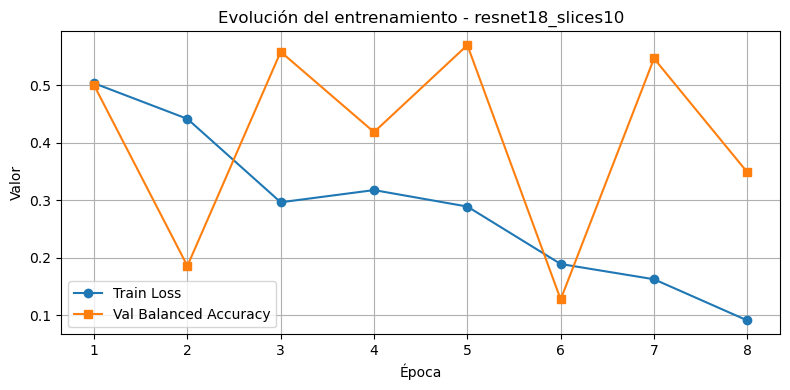

Gráfico guardado en: models_output/history_resnet18_slices10.png
Test BAC (resnet18): 0.5278
Modelo guardado: models_output/resnet18_Slices10_Learning0.0001_model.pth

=== Entrenando resnet34 ===
Epoch 1/20 | Loss 0.5739 | Val BAC 0.5000 | Tiempo 4.12 minutos
Epoch 2/20 | Loss 0.4786 | Val BAC 0.5000 | Tiempo 15.39 minutos
Epoch 3/20 | Loss 0.4291 | Val BAC 0.5000 | Tiempo 4.67 minutos
Epoch 4/20 | Loss 0.2817 | Val BAC 0.4855 | Tiempo 4.69 minutos
Early stopping activado en epoch 4
Entrenamiento completo en 28.86 minutos


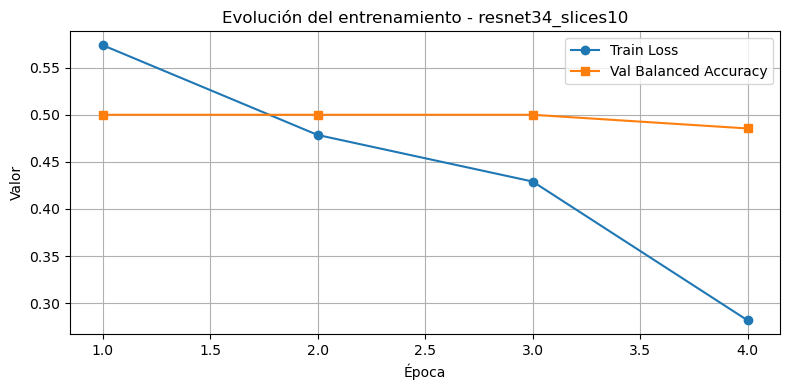

Gráfico guardado en: models_output/history_resnet34_slices10.png
Test BAC (resnet34): 0.5417
Modelo guardado: models_output/resnet34_Slices10_Learning0.0001_model.pth

Resumen:
resnet18: 0.5278
resnet34: 0.5417


In [11]:
# 1. 
N_SLICES = 10
LR = 1e-4
main(dry_run=False)

Los modelos fueron evaluados en 20 épocas, con 10 slices, learning rate 1e-4 y un early stopping de patience 3. El modelo ResNet18 mostró un comportamiento inestable a lo largo del entrenamiento. Aunque el loss disminuyó progresivamente hasta 0.09, el Balanced Accuracy (BAC) de validación fluctuó significativamente entre 0.12 y 0.57, sin una tendencia clara de mejora. El early stopping se activó en la época 8, lo que indica que el modelo dejó de generalizar pronto. En el conjunto de prueba, obtuvo un BAC de 0.5278, lo que sugiere un desempeño apenas por encima del azar en un problema binario, con una capacidad limitada para discriminar entre clases. El modelo ResNet34, también activó el early stopping rápidamente (época 4), pero mantuvo un comportamiento más estable: el BAC de validación se mantuvo alrededor de 0.50 durante todo el entrenamiento, con una pérdida que descendió desde 0.57 hasta 0.28. Aunque no mostró mejoras notables en validación, en el conjunto de prueba alcanzó un BAC de 0.5417, levemente superior al de ResNet18. Esto indica que, a pesar de entrenar menos épocas, la mayor capacidad del modelo permitió una mejor generalización leve sobre los datos de prueba.

En general, ambos modelos presentan desempeños similares y cercanos al azar, lo que sugiere que la información disponible en las 10 slices por volumen podría no ser suficiente para distinguir las clases con claridad. Sin embargo, ResNet34 logró un BAC ligeramente superior (0.5417 vs 0.5278), evidenciando una mejor capacidad de generalización gracias a su mayor profundidad, aunque a costa de un tiempo de entrenamiento más alto (28.86 vs 36.77 minutos totales, con más consumo de recursos por época).

Volúmenes encontrados: 279
Clases: 0=74, 1=116, pos_weight=0.64
Bach 8, slices 10, epocas 20

=== Entrenando resnet18 ===
Epoch 1/20 | Loss 0.5615 | Val BAC 0.2093 | Tiempo 3.22 minutos
Epoch 2/20 | Loss 0.4972 | Val BAC 0.5000 | Tiempo 2.85 minutos
Epoch 3/20 | Loss 0.4392 | Val BAC 0.5116 | Tiempo 3.07 minutos
Epoch 4/20 | Loss 0.4311 | Val BAC 0.1163 | Tiempo 2.97 minutos
Epoch 5/20 | Loss 0.3891 | Val BAC 0.3663 | Tiempo 2.91 minutos
Epoch 6/20 | Loss 0.3365 | Val BAC 0.4215 | Tiempo 2.93 minutos
Early stopping activado en epoch 6
Entrenamiento completo en 17.96 minutos


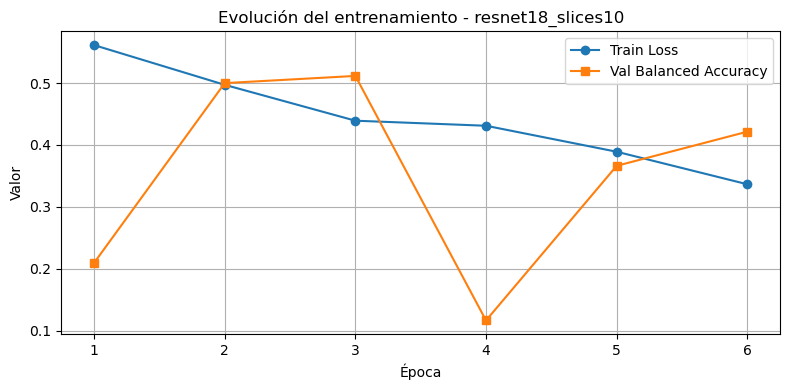

Gráfico guardado en: models_output/history_resnet18_slices10.png
Test BAC (resnet18): 0.0833
Modelo guardado: models_output/resnet18_Slices10_Learning3e-05_model.pth

=== Entrenando resnet34 ===
Epoch 1/20 | Loss 0.5507 | Val BAC 0.5000 | Tiempo 4.42 minutos
Epoch 2/20 | Loss 0.4926 | Val BAC 0.5000 | Tiempo 8.57 minutos
Epoch 3/20 | Loss 0.4875 | Val BAC 0.1512 | Tiempo 4.41 minutos
Epoch 4/20 | Loss 0.3841 | Val BAC 0.5581 | Tiempo 5.63 minutos
Epoch 5/20 | Loss 0.3685 | Val BAC 0.5000 | Tiempo 4.49 minutos
Epoch 6/20 | Loss 0.3324 | Val BAC 0.6279 | Tiempo 4.34 minutos
Epoch 7/20 | Loss 0.2456 | Val BAC 0.6047 | Tiempo 4.30 minutos
Epoch 8/20 | Loss 0.1524 | Val BAC 0.5378 | Tiempo 4.64 minutos
Epoch 9/20 | Loss 0.1160 | Val BAC 0.4070 | Tiempo 4.41 minutos
Early stopping activado en epoch 9
Entrenamiento completo en 45.20 minutos


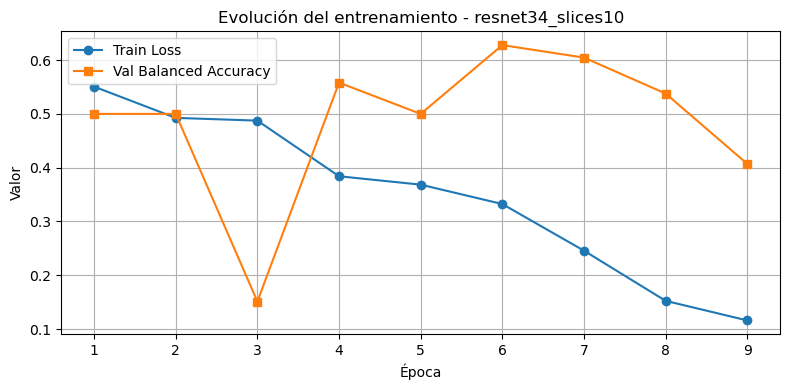

Gráfico guardado en: models_output/history_resnet34_slices10.png
Test BAC (resnet34): 0.4861
Modelo guardado: models_output/resnet34_Slices10_Learning3e-05_model.pth

Resumen:
resnet18: 0.0833
resnet34: 0.4861


In [12]:
#2. 
N_SLICES = 10
LR =  3e-5
main(dry_run=False)

El modelo ResNet18 con tasa de aprendizaje 3e-05 mostró un comportamiento deficiente. Aunque el loss descendió gradualmente de 0.56 a 0.33, el Balanced Accuracy (BAC) de validación fue extremadamente inestable, oscilando entre valores tan bajos como 0.11 y un máximo de 0.51, sin evidenciar un patrón claro de mejora. El early stopping se activó en la época 6, reflejando una falta de convergencia real. El desempeño en el conjunto de prueba (BAC = 0.0833) confirma que el modelo no logró aprender una separación útil entre las clases, posiblemente debido a una combinación de tasa de aprendizaje demasiado baja y capacidad limitada del modelo para extraer características discriminantes de las 10 slices por volumen.

En contraste, el modelo ResNet34 logró un entrenamiento más prolongado y estable. La pérdida disminuyó de 0.55 a 0.15, y el BAC de validación mostró una mejora sostenida, alcanzando valores de hasta 0.62 antes de la detención temprana en la época 9. Esto sugiere que la mayor profundidad de la red le permitió capturar patrones más relevantes, aunque aún con fluctuaciones que indican cierta sobreajuste o variabilidad en la validación. En el conjunto de prueba obtuvo un BAC de 0.4861, un resultado moderado pero claramente superior al de ResNet18, lo que evidencia mejor capacidad de generalización.

Volúmenes encontrados: 279
Clases: 0=74, 1=116, pos_weight=0.64
Bach 8, slices 20, epocas 20

=== Entrenando resnet18 ===
Epoch 1/20 | Loss 0.5632 | Val BAC 0.5000 | Tiempo 2.82 minutos
Epoch 2/20 | Loss 0.4215 | Val BAC 0.6047 | Tiempo 2.74 minutos
Epoch 3/20 | Loss 0.3838 | Val BAC 0.5930 | Tiempo 3.00 minutos
Epoch 4/20 | Loss 0.2682 | Val BAC 0.3895 | Tiempo 3.01 minutos
Epoch 5/20 | Loss 0.1956 | Val BAC 0.6512 | Tiempo 3.17 minutos
Epoch 6/20 | Loss 0.1314 | Val BAC 0.5930 | Tiempo 3.34 minutos
Epoch 7/20 | Loss 0.1446 | Val BAC 0.6628 | Tiempo 3.17 minutos
Epoch 8/20 | Loss 0.0920 | Val BAC 0.5000 | Tiempo 2.92 minutos
Epoch 9/20 | Loss 0.1200 | Val BAC 0.6744 | Tiempo 3.11 minutos
Epoch 10/20 | Loss 0.1480 | Val BAC 0.4884 | Tiempo 3.17 minutos
Epoch 11/20 | Loss 0.1100 | Val BAC 0.6163 | Tiempo 3.55 minutos
Epoch 12/20 | Loss 0.0565 | Val BAC 0.4244 | Tiempo 3.10 minutos
Early stopping activado en epoch 12
Entrenamiento completo en 37.11 minutos


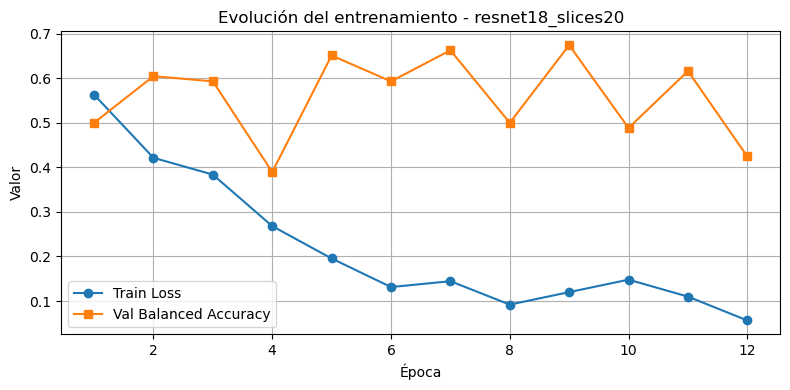

Gráfico guardado en: models_output/history_resnet18_slices20.png
Test BAC (resnet18): 0.6389
Modelo guardado: models_output/resnet18_Slices20_Learning0.0001_model.pth

=== Entrenando resnet34 ===
Epoch 1/20 | Loss 0.5143 | Val BAC 0.5000 | Tiempo 5.52 minutos
Epoch 2/20 | Loss 0.4656 | Val BAC 0.1279 | Tiempo 4.80 minutos
Epoch 3/20 | Loss 0.3906 | Val BAC 0.5000 | Tiempo 4.58 minutos
Epoch 4/20 | Loss 0.2551 | Val BAC 0.5233 | Tiempo 6.63 minutos
Epoch 5/20 | Loss 0.2435 | Val BAC 0.5029 | Tiempo 9.13 minutos
Epoch 6/20 | Loss 0.1495 | Val BAC 0.6047 | Tiempo 6.40 minutos
Epoch 7/20 | Loss 0.2073 | Val BAC 0.4477 | Tiempo 3.91 minutos
Epoch 8/20 | Loss 0.1367 | Val BAC 0.4913 | Tiempo 6.20 minutos
Epoch 9/20 | Loss 0.1233 | Val BAC 0.3547 | Tiempo 21.06 minutos
Early stopping activado en epoch 9
Entrenamiento completo en 68.23 minutos


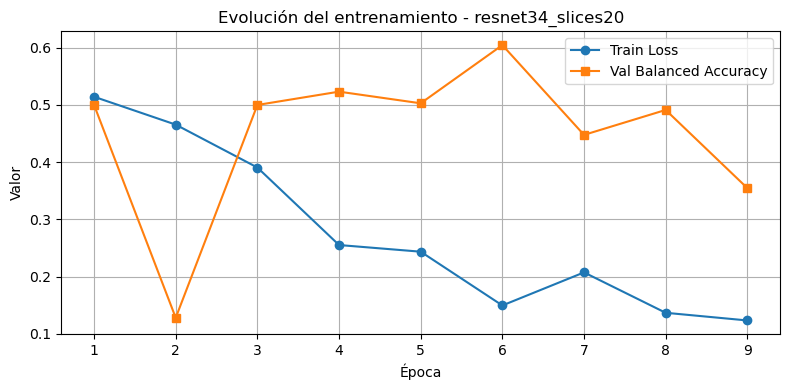

Gráfico guardado en: models_output/history_resnet34_slices20.png
Test BAC (resnet34): 0.4444
Modelo guardado: models_output/resnet34_Slices20_Learning0.0001_model.pth

Resumen:
resnet18: 0.6389
resnet34: 0.4444


In [13]:
#3.
N_SLICES = 20
LR = 1e-4
main(dry_run=False)

El modelo ResNet18 mostró un entrenamiento más estable y efectivo que en configuraciones anteriores. La pérdida disminuyó de 0.56 a 0.05, con mejoras progresivas en el Balanced Accuracy (BAC) de validación, alcanzando valores de hasta 0.67 antes del early stopping en la época 12. Esto indica que el modelo logró capturar patrones discriminantes más sólidos gracias al aumento en el número de slices, lo que le permitió disponer de mayor información estructural por volumen. El rendimiento en prueba (BAC = 0.6389) confirma una buena capacidad de generalización, mostrando que el modelo puede distinguir entre clases con una precisión equilibrada notablemente superior al azar.

El modelo ResNet34, a pesar de su mayor profundidad, tuvo un comportamiento más irregular. Aunque la pérdida bajó consistentemente (de 0.51 a 0.12), el BAC de validación fluctuó en un rango amplio, con valores que oscilaron entre 0.12 y 0.60, sin una tendencia sostenida de mejora. El early stopping se activó en la época 9, reflejando una falta de convergencia estable. En el conjunto de prueba, obtuvo un BAC de 0.4444, considerablemente inferior al de ResNet18. Esto sugiere que, bajo esta configuración, la profundidad adicional de ResNet34 no se tradujo en un mejor aprovechamiento de los datos, y pudo incluso provocar sobreajuste prematuro o dificultad de optimización debido a la tasa de aprendizaje o al tamaño del conjunto.

En este experimento, el modelo más simple (ResNet18) superó claramente al más profundo (ResNet34) tanto en validación como en prueba (0.6389 vs 0.4444 de BAC). Esto indica que el aumento de slices (de 10 a 20) benefició especialmente a ResNet18, permitiéndole capturar mejor las características relevantes sin sobreajustar. En cambio, ResNet34 parece haber perdido capacidad de generalización, probablemente porque su complejidad excede la cantidad efectiva de datos disponibles. En conjunto, los resultados muestran que, con 20 slices, ResNet18 alcanza un equilibrio óptimo entre profundidad, estabilidad y generalización, mientras que ResNet34 requiere ajustes más finos de regularización o tasa de aprendizaje para aprovechar su potencial.

Volúmenes encontrados: 279
Clases: 0=74, 1=116, pos_weight=0.64
Bach 8, slices 30, epocas 20

=== Entrenando resnet18 ===
Epoch 1/20 | Loss 0.5035 | Val BAC 0.5000 | Tiempo 3.52 minutos
Epoch 2/20 | Loss 0.4416 | Val BAC 0.1860 | Tiempo 3.50 minutos
Epoch 3/20 | Loss 0.2967 | Val BAC 0.5581 | Tiempo 3.47 minutos
Epoch 4/20 | Loss 0.3179 | Val BAC 0.4186 | Tiempo 3.71 minutos
Epoch 5/20 | Loss 0.2892 | Val BAC 0.5698 | Tiempo 4.01 minutos
Epoch 6/20 | Loss 0.1894 | Val BAC 0.1279 | Tiempo 3.20 minutos
Epoch 7/20 | Loss 0.1629 | Val BAC 0.5465 | Tiempo 3.17 minutos
Epoch 8/20 | Loss 0.0914 | Val BAC 0.3488 | Tiempo 4.46 minutos
Early stopping activado en epoch 8
Entrenamiento completo en 29.04 minutos


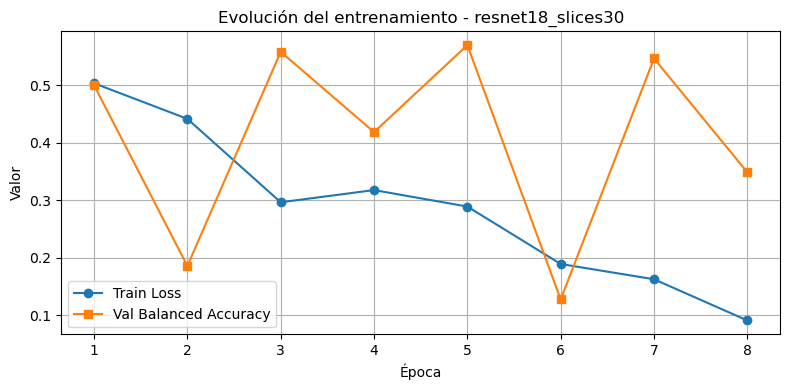

Gráfico guardado en: models_output/history_resnet18_slices30.png
Test BAC (resnet18): 0.5278
Modelo guardado: models_output/resnet18_Slices30_Learning0.0001_model.pth

=== Entrenando resnet34 ===
Epoch 1/20 | Loss 0.5739 | Val BAC 0.5000 | Tiempo 4.74 minutos
Epoch 2/20 | Loss 0.4786 | Val BAC 0.5000 | Tiempo 4.50 minutos
Epoch 3/20 | Loss 0.4291 | Val BAC 0.5000 | Tiempo 4.70 minutos
Epoch 4/20 | Loss 0.2817 | Val BAC 0.4855 | Tiempo 4.46 minutos
Early stopping activado en epoch 4
Entrenamiento completo en 18.41 minutos


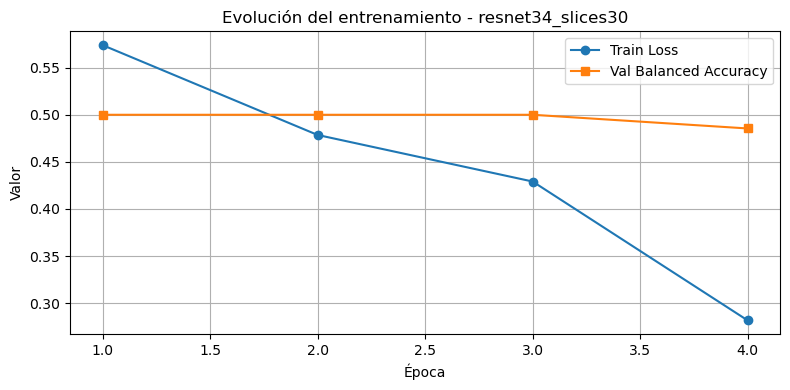

Gráfico guardado en: models_output/history_resnet34_slices30.png
Test BAC (resnet34): 0.5417
Modelo guardado: models_output/resnet34_Slices30_Learning0.0001_model.pth

Resumen:
resnet18: 0.5278
resnet34: 0.5417


In [ ]:
#4.
N_SLICES = 30
LR = 1e-4
main(dry_run=False)

> Los siguientes son entrenados con paciencia 5

Volúmenes encontrados: 279
Clases: 0=74, 1=116, pos_weight=0.64
Bach 8, slices 20, epocas 30

=== Entrenando resnet18 ===
Epoch 1/30 | Loss 0.5766 | Val BAC 0.3983 | Tiempo 3.17 minutos
Epoch 2/30 | Loss 0.4752 | Val BAC 0.5581 | Tiempo 3.07 minutos
Epoch 3/30 | Loss 0.3898 | Val BAC 0.1977 | Tiempo 3.31 minutos
Epoch 4/30 | Loss 0.2777 | Val BAC 0.5814 | Tiempo 3.32 minutos
Epoch 5/30 | Loss 0.1913 | Val BAC 0.5465 | Tiempo 3.38 minutos
Epoch 6/30 | Loss 0.2245 | Val BAC 0.2209 | Tiempo 3.33 minutos
Epoch 7/30 | Loss 0.1735 | Val BAC 0.3343 | Tiempo 3.30 minutos
Epoch 8/30 | Loss 0.1382 | Val BAC 0.4913 | Tiempo 3.33 minutos
Epoch 9/30 | Loss 0.1085 | Val BAC 0.5930 | Tiempo 3.37 minutos
Epoch 10/30 | Loss 0.0969 | Val BAC 0.6279 | Tiempo 3.30 minutos
Epoch 11/30 | Loss 0.0524 | Val BAC 0.6163 | Tiempo 3.26 minutos
Epoch 12/30 | Loss 0.0464 | Val BAC 0.6163 | Tiempo 3.42 minutos
Epoch 13/30 | Loss 0.0864 | Val BAC 0.6279 | Tiempo 3.35 minutos
Epoch 14/30 | Loss 0.0655 | Val BAC 0.6047

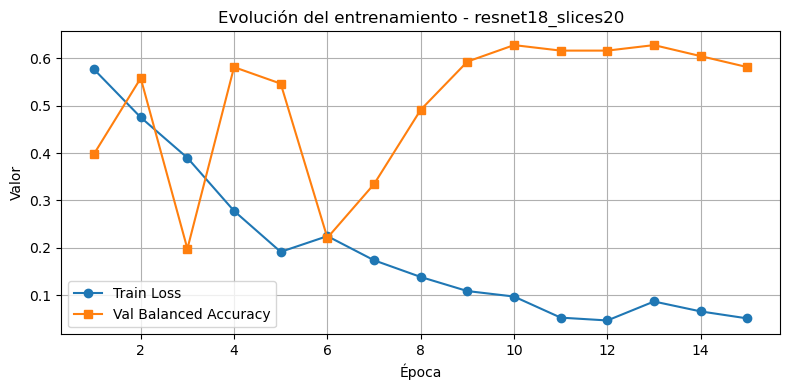

Gráfico guardado en: models_output/history_resnet18_slices20.png
Test BAC (resnet18): 0.4444
Modelo guardado: models_output/resnet18_Slices20_Learning0.0001_model.pth

=== Entrenando resnet34 ===
Epoch 1/30 | Loss 0.5225 | Val BAC 0.3547 | Tiempo 4.98 minutos
Epoch 2/30 | Loss 0.5132 | Val BAC 0.5000 | Tiempo 4.97 minutos
Epoch 3/30 | Loss 0.4025 | Val BAC 0.3372 | Tiempo 5.26 minutos
Epoch 4/30 | Loss 0.2936 | Val BAC 0.5581 | Tiempo 5.17 minutos
Epoch 5/30 | Loss 0.2962 | Val BAC 0.3808 | Tiempo 5.21 minutos
Epoch 6/30 | Loss 0.2415 | Val BAC 0.4709 | Tiempo 5.10 minutos
Epoch 7/30 | Loss 0.2154 | Val BAC 0.4797 | Tiempo 5.25 minutos
Epoch 8/30 | Loss 0.0698 | Val BAC 0.3779 | Tiempo 5.06 minutos
Epoch 9/30 | Loss 0.0925 | Val BAC 0.5959 | Tiempo 5.03 minutos
Epoch 10/30 | Loss 0.1373 | Val BAC 0.6163 | Tiempo 6.67 minutos
Epoch 11/30 | Loss 0.0606 | Val BAC 0.5698 | Tiempo 7.03 minutos
Epoch 12/30 | Loss 0.0431 | Val BAC 0.4244 | Tiempo 5.05 minutos
Epoch 13/30 | Loss 0.0641 | Val B

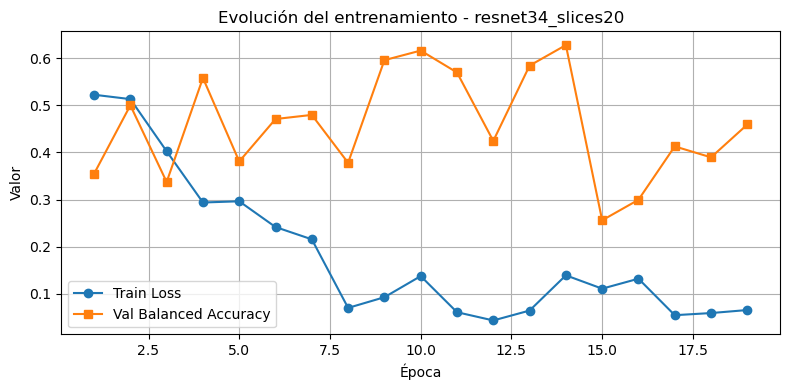

Gráfico guardado en: models_output/history_resnet34_slices20.png
Test BAC (resnet34): 0.5417
Modelo guardado: models_output/resnet34_Slices20_Learning0.0001_model.pth

Resumen:
resnet18: 0.4444
resnet34: 0.5417


In [13]:
#5.
EPOCHS = 30
N_SLICES = 20
LR = 1e-4
main(dry_run=False)

El modelo ResNet18 mostró un comportamiento de entrenamiento más prolongado y estable, con una reducción de loss significativa (de 0.57 a 0.05) y valores de Balanced Accuracy (BAC) en validación que oscilaron entre 0.19 y 0.67. Aun así, las fluctuaciones entre épocas indican cierta inestabilidad en la capacidad de generalización, probablemente derivada de una mayor cantidad de épocas que favoreció un leve sobreajuste. El early stopping se activó en la época 15, cuando el modelo ya no mejoraba consistentemente en validación. En prueba, obtuvo un BAC de 0.4444, lo que representa un rendimiento moderado, por debajo de lo esperado considerando el buen ajuste en validación, confirmando que parte del aprendizaje fue específico al conjunto de entrenamiento.
El modelo ResNet34 mostró un patrón de mejora más gradual pero más robusto. La pérdida bajó de 0.52 a 0.06, y el BAC de validación alcanzó un máximo de 0.63, con fluctuaciones menores que las observadas en ResNet18. El early stopping ocurrió más tarde, en la época 19, lo que indica que la red más profunda siguió aprendiendo de manera efectiva durante más tiempo. En el conjunto de prueba alcanzó un BAC de 0.5417, demostrando mayor capacidad de generalización frente al modelo más simple. Aunque el entrenamiento fue más largo (99 minutos frente a 49 de ResNet18), la ganancia en desempeño justifica el costo computacional.
Con 20 slices y 30 épocas, la ResNet34 superó consistentemente a la ResNet18 tanto en validación como en prueba (0.5417 vs 0.4444 de BAC). Esto sugiere que, al aumentar las épocas, la profundidad adicional de ResNet34 se aprovechó mejor, permitiéndole extraer características más complejas y generalizables. Por el contrario, ResNet18 parece haber alcanzado su límite de representación, beneficiándose menos del entrenamiento extendido y mostrando signos de sobreajuste. En conjunto, estos resultados evidencian que, bajo una configuración más larga de entrenamiento, ResNet34 logra un mejor equilibrio entre aprendizaje y generalización, aunque a costa de mayor tiempo computacional.

| **Modelo**   | **Slices** | **Épocas Totales** | **Learning Rate** | **Época de Stop** | **Tiempo Total (min)** | **Test BAC** | **Promedio Épocas/Stop (% del total)** |
| ------------ | ---------- | ------------------ | ----------------- | ----------------- | ---------------------- | ------------ | -------------------------------------- |
| **ResNet18** | 10         | 20                 | 0.0001            | 8                 | 36.77                  | 0.5278       | 40%                                    |
| **ResNet34** | 10         | 20                 | 0.0001            | 4                 | 28.86                  | 0.5417       | 20%                                    |
| **ResNet18** | 10         | 20                 | 0.00003           | 6                 | 17.96                  | 0.0833       | 30%                                    |
| **ResNet34** | 10         | 20                 | 0.00003           | 9                 | 45.20                  | 0.4861       | 45%                                    |
| **ResNet18** | 20         | 20                 | 0.0001            | 12                | 37.11                  | 0.6389       | 60%                                    |
| **ResNet34** | 20         | 20                 | 0.0001            | 9                 | 68.23                  | 0.4444       | 45%                                    |
| **ResNet18** | 20         | 30                 | 0.0001            | 15                | 49.72                  | 0.4444       | 50%                                    |
| **ResNet34** | 20         | 30                 | 0.0001            | 19                | 99.04                  | 0.5417       | 63%                                    |


Mejor desempeño global: ResNet18 con 20 slices (BAC = 0.6389)\
Logró el mejor equilibrio entre profundidad, número de slices y estabilidad.

ResNet34 mostró mejoras con más épocas, pero un aumento considerable del tiempo de entrenamiento.

El learning rate más bajo (3e-5) no favoreció el rendimiento, produciendo los valores más bajos de BAC, especialmente en ResNet18.

El porcentaje de época de stop respecto al total indica que ResNet18 suele converger más rápido (40–60%), mientras que ResNet34 necesita más tiempo (45–63%), lo cual es coherente con su mayor profundidad y complejidad.